# Benchmarking a TCR Beta embedder model

## Setup

In [36]:
import os
from pathlib import Path
import sys

if "__project_dir__" not in globals():
    __project_dir__ = Path.cwd().parents[1].resolve()

sys.path.append(__project_dir__)
os.chdir(__project_dir__)

In [37]:
import json
from matplotlib import pyplot as plt
import pandas as pd
import seaborn
from src import modules
import torch

seaborn.set_theme()
seaborn.set_style("white")

### Select model

In [38]:
model_save_dir = Path(
    "/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/model_saves/BetaCDR3BERT_ap"
)
with open(model_save_dir / "config.json", "r") as f:
    config = json.load(f)
model = modules.BetaCDR3BERT_ap(**config["model"]["config"])
model.load_state_dict(torch.load(model_save_dir / "state_dict.pt"))

<All keys matched successfully>

### Load training log

In [39]:
training_log = pd.read_csv(model_save_dir / "log.csv")

In [40]:
training_log

,epoch,loss,lr,valid_loss,valid_acc,valid_top5_acc
0,1,1.934576,0.000064,1.535824,0.657657,0.852665
1,2,1.460554,0.000191,1.445925,0.690775,0.870931
2,3,1.402620,0.000318,1.422470,0.698346,0.874959
3,4,1.382157,0.000445,1.410517,0.701465,0.878503
4,5,1.375026,0.000572,1.408233,0.701719,0.878244
5,6,1.369564,0.000700,1.406445,0.701862,0.879038
6,7,1.366941,0.000827,1.405469,0.704450,0.881068
7,8,1.363038,0.000851,1.400994,0.704007,0.881221
8,9,1.358839,0.000800,1.391279,0.707126,0.882822
9,10,1.356359,0.000756,1.396588,0.706050,0.881381


### Create benchmarking directory

In [41]:
BENCHMARK_DIR = Path(f"benchmarks_beta/{model.name}")
if not BENCHMARK_DIR.is_dir():
    BENCHMARK_DIR.mkdir()

## MLM analysis

### Figures

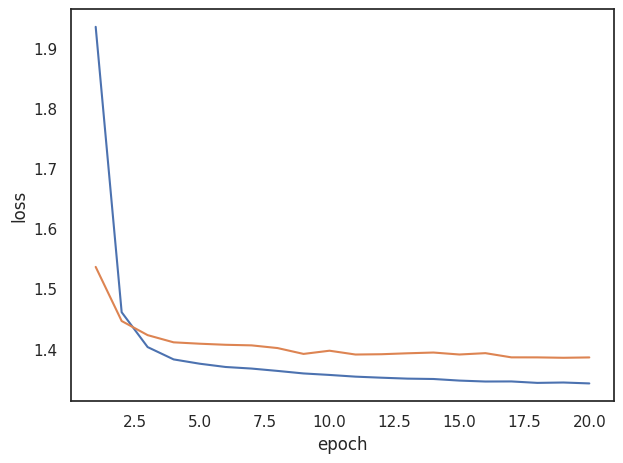

In [42]:
seaborn.lineplot(training_log, x="epoch", y="loss")
seaborn.lineplot(training_log, x="epoch", y="valid_loss")
plt.tight_layout()
plt.savefig(BENCHMARK_DIR / "loss.png")

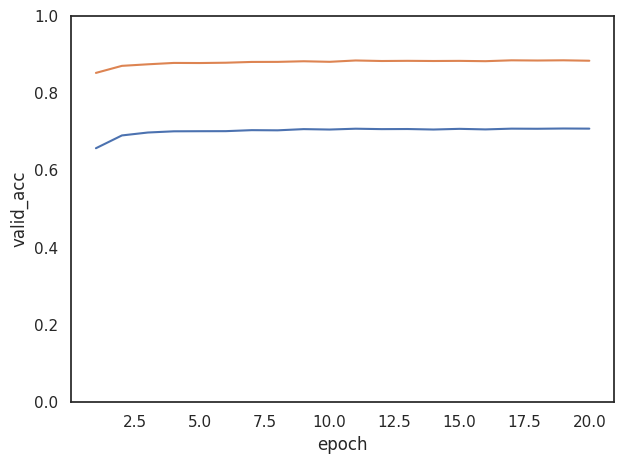

In [43]:
seaborn.lineplot(training_log, x="epoch", y="valid_acc")
seaborn.lineplot(training_log, x="epoch", y="valid_top5_acc")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(BENCHMARK_DIR / "mlm_acc.png")

### JSON

In [44]:
if (BENCHMARK_DIR / "metrics.json").is_file():
    with open(BENCHMARK_DIR / "metrics.json", "r") as f:
        metrics_dict = json.load(f)
else:
    metrics_dict = dict()

In [45]:
metrics_dict["mlm"] = {
    "top1_acc": training_log["valid_acc"].iloc[-1].item(),
    "top5_acc": training_log["valid_top5_acc"].iloc[-1].item(),
}

In [46]:
with open(BENCHMARK_DIR / "metrics.json", "w") as f:
    json.dump(metrics_dict, f, indent=4)